In [40]:
import numpy as np
import pandas as pd

from mplchart.samples import sample_prices   


In [41]:
prices = sample_prices()
prices

,open,high,low,close,volume
date,,,,,
1980-12-12,0.099058,0.099488,0.099058,0.099058,469033600
1980-12-15,0.094321,0.094321,0.093890,0.093890,175884800
1980-12-16,0.087429,0.087429,0.086999,0.086999,105728000
1980-12-17,0.089152,0.089582,0.089152,0.089152,86441600
1980-12-18,0.091736,0.092167,0.091736,0.091736,73449600
...,...,...,...,...,...
2024-05-29,189.610001,192.250000,189.509995,190.289993,53068000
2024-05-30,190.759995,192.179993,190.630005,191.289993,49947900
2024-05-31,191.440002,192.570007,189.910004,192.250000,75158300


In [42]:
""" Parabolic Stop and Reverse """


def calc_sar(prices, afs: float=0.02, maxaf: float=0.2):
    """
    Parabolic Stop and Reverse
    
    Args:
        afs (float) : starting acceleration factor, default 0.02
        maxaf (float) : maximum acceleration factor, default 0.2
    """

    data = prices[['high', 'low']].values
    size = data.shape[0]
    output = np.full(size, np.nan)

    ep = sar = af = trend = np.nan
    ph = pl = hi = lo = np.nan

    for i in range(size):
        if hi >= lo:
            ph, pl = hi, lo

        hi, lo = data[i]

        if not (hi >= lo and ph >= pl):
            continue

        hi2 = ph if ph > hi else hi
        lo2 = pl if pl < lo else lo

        # check for reversal
        if trend > 0 and lo < sar:
            ep, sar, af, trend = lo, ep, afs, -1

        elif trend < 0 and hi > sar:
            ep, sar, af, trend = hi, ep, afs, +1

        output[i] = sar

        # calculate next sar
        if trend != trend:
            # initialize sar
            if hi > ph:
                ep, sar, af, trend = hi2, lo2, afs, +1
            else:
                ep, sar, af, trend = lo2, hi2, afs, -1
        else:
            # update sar
            sar += af * (ep - sar)
            # adjust sar, ep, af if needed
            if trend > 0:
                if lo2 < sar:
                    sar = lo2
                if hi > ep:
                    ep = hi
                    af += afs
            if trend < 0:
                if hi2 > sar:
                    sar = hi2
                if lo < ep:
                    ep = lo
                    af += afs

        if maxaf and af > maxaf:
            af = maxaf

    result = pd.Series(output, index=prices.index)

    return result





In [43]:
calc_sar(prices)

date
1980-12-12           NaN
1980-12-15           NaN
1980-12-16      0.099488
1980-12-17      0.099376
1980-12-18      0.098881
                 ...    
2024-05-29    186.800351
2024-05-30    188.040281
2024-05-31    189.032225
2024-06-03    189.825780
2024-06-04    189.910004
Length: 10960, dtype: float64

In [44]:
%timeit calc_sar(prices)

7.21 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
from mplchart.model import Indicator


class SAR(Indicator):
    """Parabolic Stop and Reverse"""

    same_scale = True
    line_style = "marker"

    def __init__(self, afs: float=0.02, maxaf: float=0.2):
        self.afs = afs
        self.maxaf = maxaf

    def __call__(self, prices):
        return calc_sar(prices, afs=self.afs, maxaf=self.maxaf)


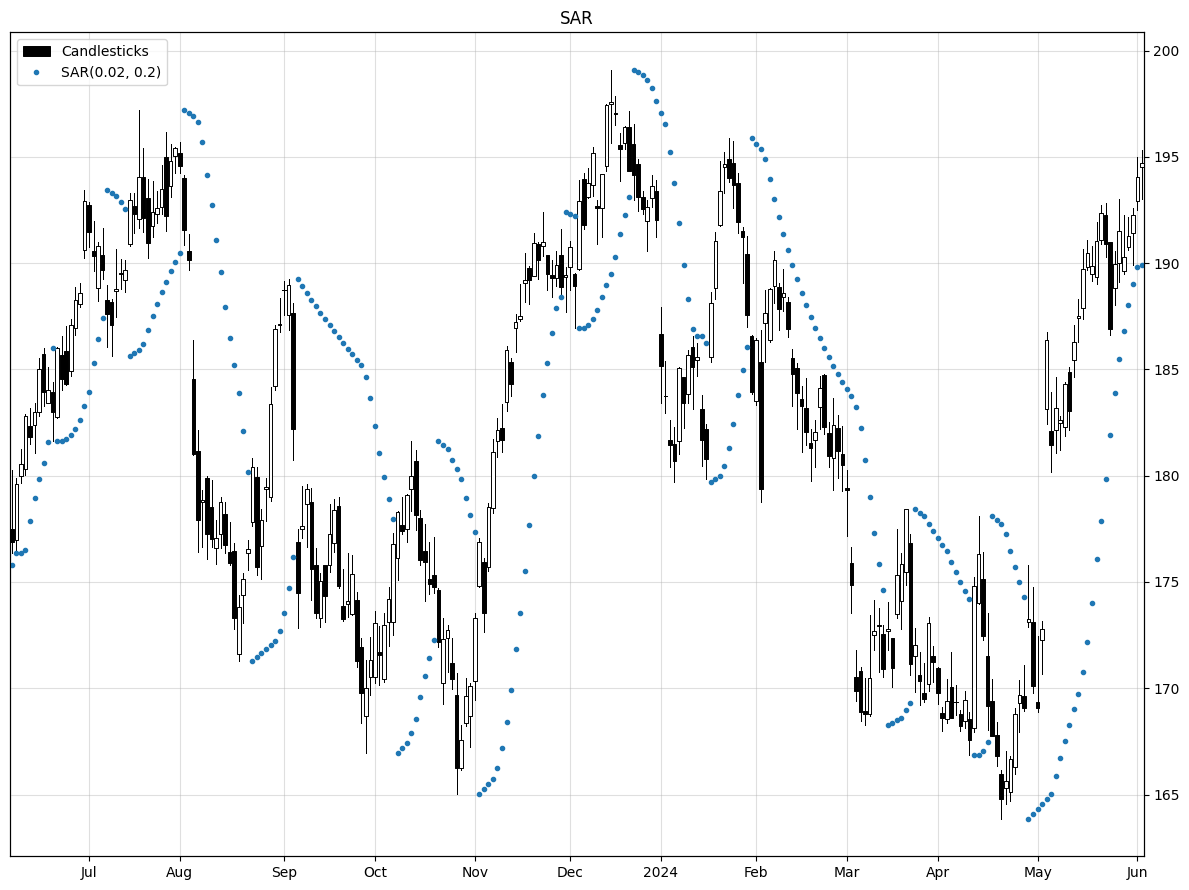

In [46]:
from mplchart.chart import Chart
from mplchart.primitives import Candlesticks

max_bars = 250

indicators = [
    Candlesticks(),
    SAR()
]

chart = Chart(title="SAR", max_bars=max_bars)
chart.plot(prices, indicators)

True